In [9]:
# DQL using tutorial from PyTorch: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html (Do not use)
# Hours wasted here: 20. Use nn.Linear with output data from env instead of images.
# Data from env -> Linear -> ReLU * n. Output will be actions.

import gym
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.transforms as t
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self):
        self.memory = []

    def record(self, *args):
        """Records a memory into the replay memory."""
        self.memory.append(Transition(*args))

    def sample(self, n):
        """Returns n random samples from the replay memory."""
        return random.sample(self.memory, n)

    def __len__(self):
        return len(self.memory)

In [11]:
class DQN(nn.Module):
    def __init__(self, height, width, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)  # Same kind of layer used in exercise 3 (CNN).
        self.bn1 = nn.BatchNorm2d(16)  # Normalizes a 4D input.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        conv2d_output_size = lambda size, kernel=5, stride=2: (size - (kernel - 1) - 1) // stride + 1
        conv_h = conv2d_output_size(conv2d_output_size(conv2d_output_size(height)))
        conv_w = conv2d_output_size(conv2d_output_size(conv2d_output_size(width)))
        self.head = nn.Linear(conv_h * conv_w * 32, outputs)

    def forward(self, v):
        data = f.relu(self.bn1(self.conv1(v)))
        data = f.relu(self.bn2(self.conv2(data)))
        data = f.relu(self.bn3(self.conv3(data)))

        return self.head(data.view(data.size(0), -1))

In [12]:
class ImageExtractor:
    def __init__(self, env):
        self.env = env
        self.resize = t.Compose([t.ToPILImage(), t.Resize(40, interpolation=t.InterpolationMode.BOX), t.ToTensor()])
        env.reset()

    def get_cart_location(self, screen_width):
        world_width = self.env.x_threshold * 2
        scale = screen_width / world_width
        return int(self.env.state[0] * scale + screen_width / 2.)

    def get_screen(self):
        screen = self.env.render().transpose((2, 0, 1))
        _, screen_height, screen_width = screen.shape

        screen = screen[:, int(screen_height * 0.4) : int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        cart_location = self.get_cart_location(screen_width)

        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)

        screen = screen[:, :, slice_range]
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        return self.resize(screen).unsqueeze(0)

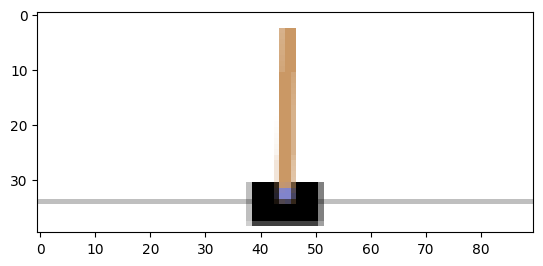

In [13]:
env = gym.make("CartPole-v1", render_mode="rgb_array").unwrapped
env.action_space.seed(42)

ie = ImageExtractor(env)
plt.figure()
plt.imshow(ie.get_screen().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none")
plt.show()

In [14]:
class DeepQLearningCartPole:
    def __init__(self, episodes=50):
        self.batch_size = 128
        self.gamma = 0.999
        self.eps_max = 0.9
        self.eps_min = 0.05
        self.eps_decay = 200
        self.target_update = 10
        self.episodes = episodes

        self.env = gym.make("CartPole-v1", render_mode="rgb_array").unwrapped
        env.action_space.seed(42)
        self.actions = self.env.action_space.n
        self.ie = ImageExtractor(env)
        self.memory = ReplayMemory()

        _, _, screen_height, screen_width = self.ie.get_screen().shape
        self.policy_net = DQN(screen_height, screen_width, self.actions)
        self.target_net = DQN(screen_height, screen_width, self.actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.steps_done = 0
        self.episode_durations = []

    def pick_action(self, state):
        eps_threshold = self.eps_min + (self.eps_max - self.eps_min) * math.exp(-1 * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if random.random() > eps_threshold:
            with torch.no_grad():
                # Return the index of the max column element in each row / the action with the larger expected reward.
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.actions)]], dtype=torch.long)

    def optimize(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # V(s_t+1) for the next possible states
        next_state_values = torch.zeros(self.batch_size)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Huber loss for smaller values
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def train(self):
        for i_episode in range(self.episodes):
            # Initialize the environment and state
            env.reset()

            last_screen = self.ie.get_screen()
            current_screen = self.ie.get_screen()
            state = current_screen - last_screen
            for t in count():
                # Select and perform an action
                action = self.pick_action(state)
                _, reward, done, _, _ = env.step(action.item())
                reward = torch.tensor([reward])

                # Observe new state
                last_screen = current_screen
                current_screen = self.ie.get_screen()

                if not done:
                    next_state = current_screen - last_screen
                else:
                    next_state = None

                # Store the transition in memory
                self.memory.record(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize()
                if done:
                    self.episode_durations.append(t + 1)
                    break

            # Update the target network, copying all weights and biases in DQN
            if i_episode % self.target_update == 0:
                print(f"Updating target network ({i_episode}/{self.episodes})")
                self.target_net.load_state_dict(self.policy_net.state_dict())

        env.render()
        env.close()

In [15]:
def plot_durations(episode_durations):
    plt.figure()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Episode durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.show()

Updating target network (0/50)
Updating target network (10/50)
Updating target network (20/50)
Updating target network (30/50)
Updating target network (40/50)


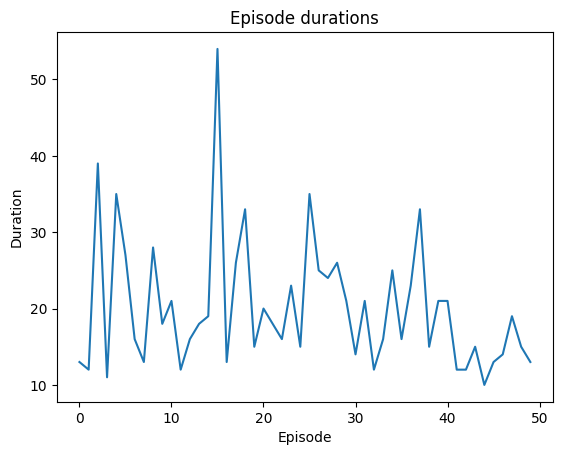

In [16]:
dql = DeepQLearningCartPole()
dql.train()
plot_durations(dql.episode_durations)
